* 18.12.22
* Yaromir Kapustin
* ver0.1

# <center>ДЗ 18. Прогноз просрочки кредита заемщиком</center>

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from tqdm import tqdm
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

### Описание набора данных

Данные представляют собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ). Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

Данная решаемая задача будет ценна как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

### Описание признаков

* 1 - __SeriousDlqin2yrs__ - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)
* 3 - __age__ - Возраст заемщика (в годах)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - количество просрочек в 30-59 дней (Целое)
* 5 - __DebtRatio__ - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)
* 6 - __Monthly Income__ - месячный доход (число с плавающей точкой)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - количество открытых кредитов и кредитных линий (Целое)
* 8 - __NumberOfTimes90DaysLate__ - количество просрочек более 90 дней (Целое)
* 9 - __NumberRealEstateLoansOrLines__ - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - количество просрочек в 60-89 дней за последние 2 года (Целое)
* 11 - __NumberOfDependents__ - количество иждивенцев в семье (исключая самих заемщиков) (Целое)

In [2]:
df = pd.read_csv('cs-training.csv', index_col=0)

In [3]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
print(df.shape)

(150000, 11)


Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам

In [5]:
#все столбцы числовые
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

Проверьте наличие NaN, при необходимости осуществите замену

О чем свидетельствуют пропуски в данных, чем их лучше заменить? Осуществите необходимую замену...

In [6]:
# колонки MonthlyIncome и NumberOfDependents содержат пропуски
df.MonthlyIncome = df.MonthlyIncome.fillna(df.MonthlyIncome.median())
df.NumberOfDependents = df.NumberOfDependents.fillna(df.NumberOfDependents.median())

Оцените количество вернувших и не вернувших кредит. Какую метрику лучше всего использовать?

In [7]:
# количество выплативших кредит в 14 раз меньше, чем должников
df.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

__Визуализация данных__

Какие существуют зависимости в данных?
Опишите зависимости каждого из признаков!

In [8]:
#в данных есть строки с редковстречающимися значениями
df.age.value_counts()

49     3837
48     3806
50     3753
47     3719
63     3719
       ... 
102       3
109       2
107       1
105       1
0         1
Name: age, Length: 86, dtype: int64

In [8]:
#удалю выбросы (возраст более 92)
df = df.loc[df['age'] < 92]

<AxesSubplot:xlabel='age', ylabel='SeriousDlqin2yrs'>

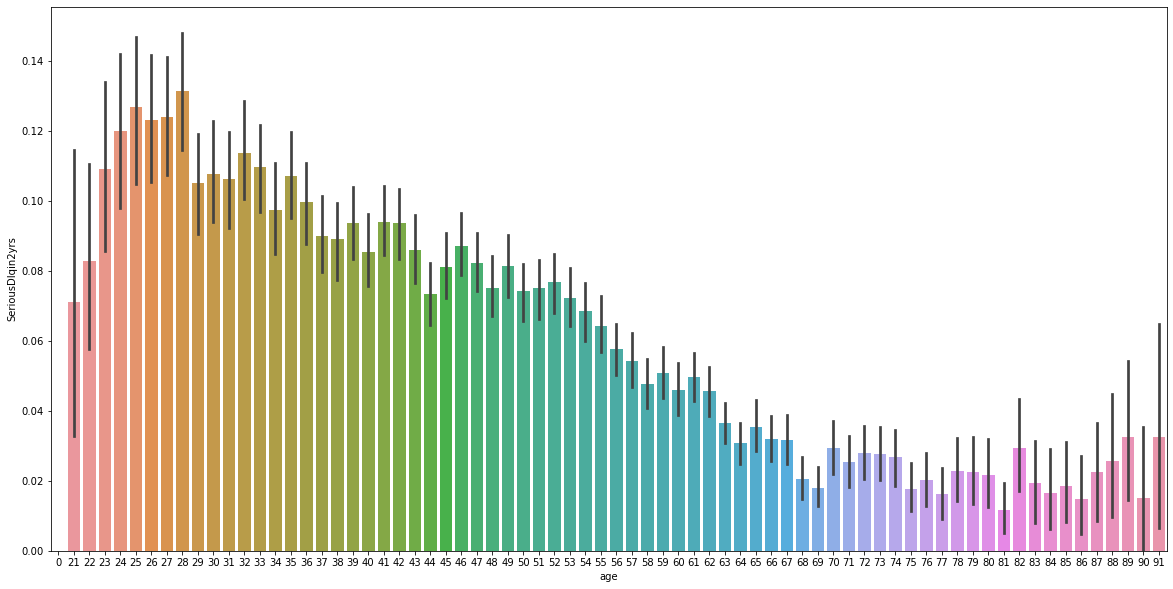

In [10]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="age", y="SeriousDlqin2yrs")

---

In [16]:
df.NumberOfDependents.value_counts()

0.0     90511
1.0     26296
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
10.0        5
9.0         5
20.0        1
13.0        1
Name: NumberOfDependents, dtype: int64

In [9]:
df = df.loc[df['NumberOfDependents'] < 10]

<AxesSubplot:xlabel='NumberOfDependents', ylabel='SeriousDlqin2yrs'>

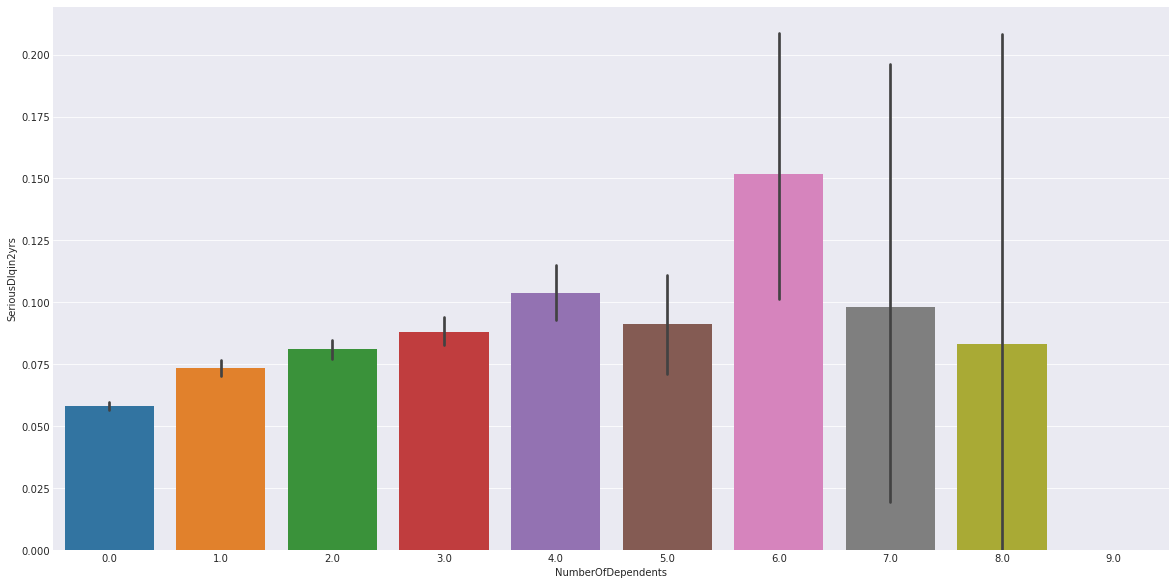

In [13]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="NumberOfDependents", y="SeriousDlqin2yrs")

---

In [14]:
df.NumberOfOpenCreditLinesAndLoans.value_counts()

6     13583
7     13216
5     12891
8     12549
4     11574
9     11343
10     9614
3      9014
11     8307
12     6998
2      6614
13     5661
14     4543
1      4404
15     3639
16     2999
17     2369
0      1887
18     1873
19     1433
20     1169
21      864
22      685
23      533
24      422
25      336
26      239
27      194
28      150
29      114
30       87
31       74
32       52
33       47
34       35
35       27
36       18
38       13
40       10
39        9
42        8
45        8
43        8
37        7
48        6
49        4
54        4
41        4
52        3
46        3
57        2
51        2
56        2
47        2
50        2
44        2
58        1
53        1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

In [10]:
df = df.loc[df['NumberOfOpenCreditLinesAndLoans'] < 36]

<AxesSubplot:xlabel='NumberOfOpenCreditLinesAndLoans', ylabel='SeriousDlqin2yrs'>

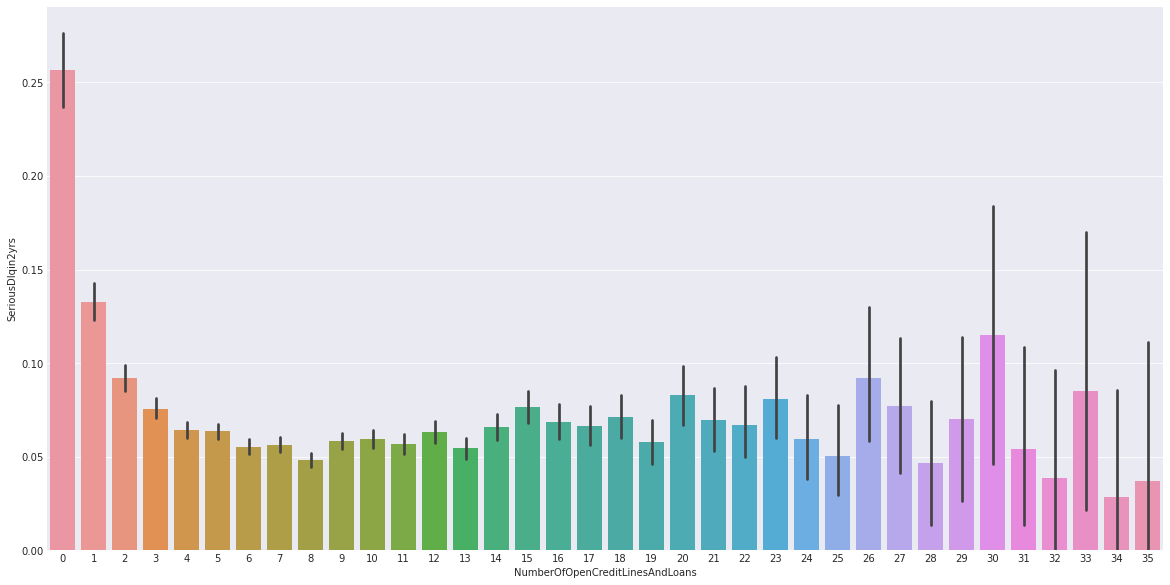

In [16]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="NumberOfOpenCreditLinesAndLoans", y="SeriousDlqin2yrs")

---

In [17]:
df.NumberRealEstateLoansOrLines.value_counts()

0     55875
1     52270
2     31478
3      6287
4      2163
5       687
6       316
7       170
8        93
9        78
10       37
11       22
12       17
13       14
15        7
14        7
17        4
16        4
18        2
23        2
19        2
26        1
21        1
20        1
25        1
Name: NumberRealEstateLoansOrLines, dtype: int64

In [11]:
df = df.loc[df['NumberRealEstateLoansOrLines'] < 12]

<AxesSubplot:xlabel='NumberRealEstateLoansOrLines', ylabel='SeriousDlqin2yrs'>

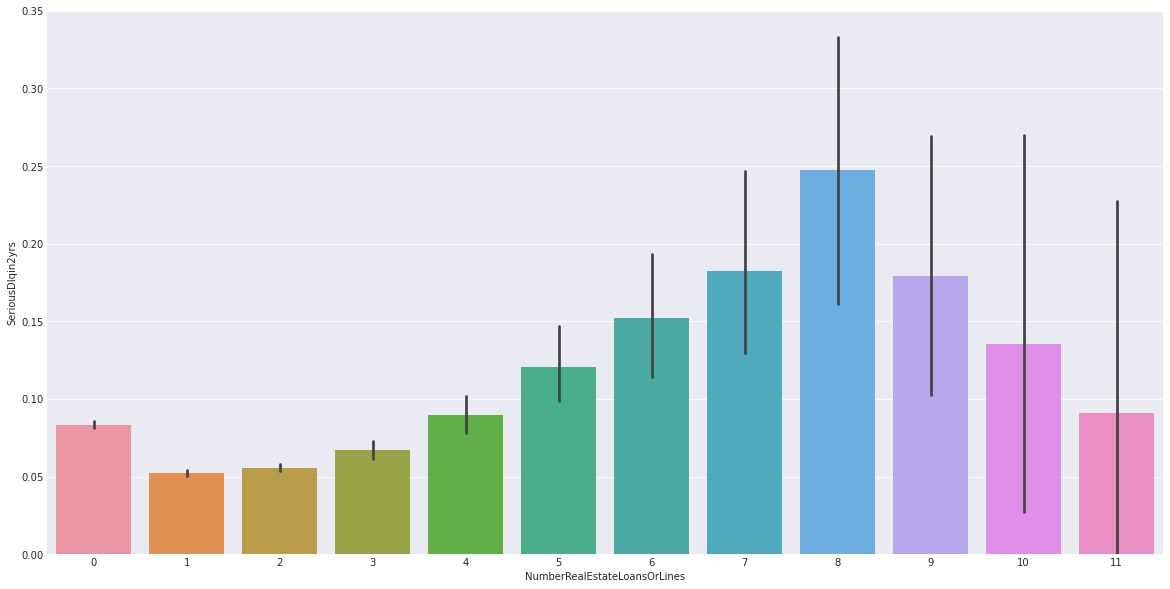

In [19]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="NumberRealEstateLoansOrLines", y="SeriousDlqin2yrs")

---

In [20]:
df.NumberOfTimes90DaysLate.value_counts()

0     141150
1       5234
2       1553
3        667
4        291
98       264
5        131
6         79
7         38
8         21
9         19
10         8
96         5
11         5
13         4
15         2
14         2
12         2
17         1
Name: NumberOfTimes90DaysLate, dtype: int64

In [12]:
df = df.loc[df['NumberOfTimes90DaysLate'] < 7]

<AxesSubplot:xlabel='NumberOfTimes90DaysLate', ylabel='SeriousDlqin2yrs'>

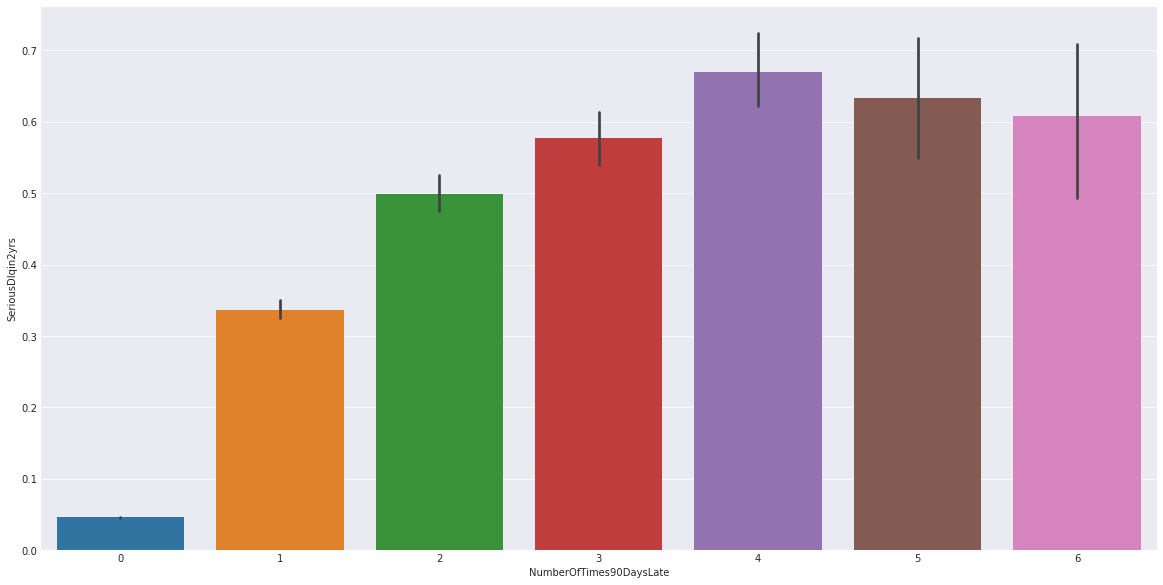

In [22]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="NumberOfTimes90DaysLate", y="SeriousDlqin2yrs")

---

In [23]:
df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()

0     125532
1      15948
2       4571
3       1742
4        738
5        338
6        139
7         53
8         24
9         12
10         4
12         2
13         1
11         1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

In [13]:
df = df.loc[df['NumberOfTime30-59DaysPastDueNotWorse'] < 8]

<AxesSubplot:xlabel='NumberOfTime30-59DaysPastDueNotWorse', ylabel='SeriousDlqin2yrs'>

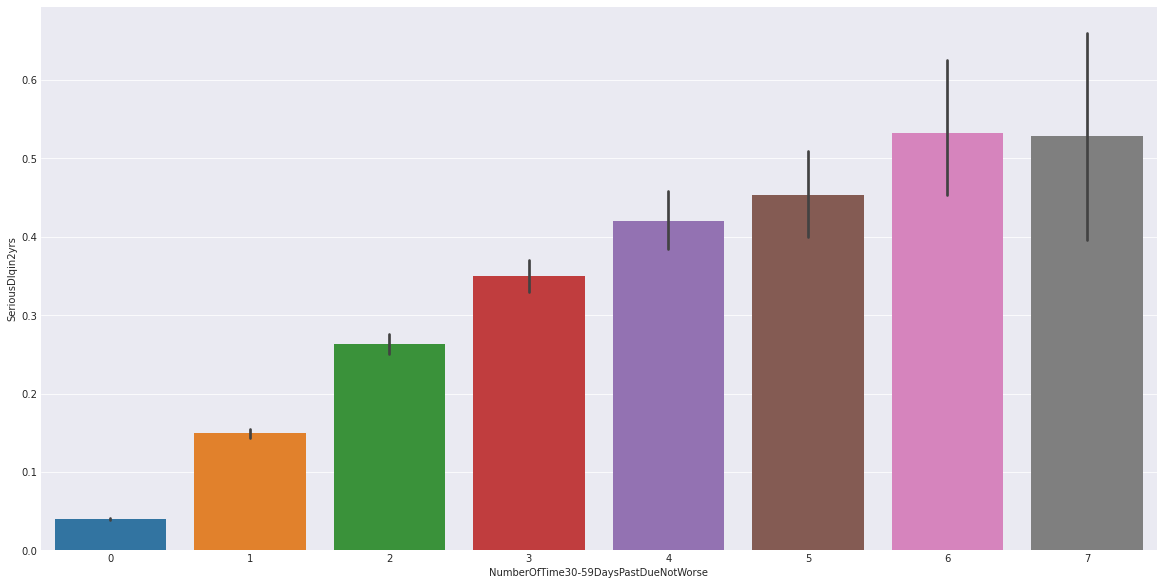

In [25]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="NumberOfTime30-59DaysPastDueNotWorse", y="SeriousDlqin2yrs")

---

In [26]:
df['NumberOfTime60-89DaysPastDueNotWorse'].value_counts()

0     141817
1       5678
2       1096
3        312
4        102
5         32
6         14
7          7
11         1
8          1
9          1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

In [14]:
df = df.loc[df['NumberOfTime60-89DaysPastDueNotWorse'] < 5]

<AxesSubplot:xlabel='NumberOfTime60-89DaysPastDueNotWorse', ylabel='SeriousDlqin2yrs'>

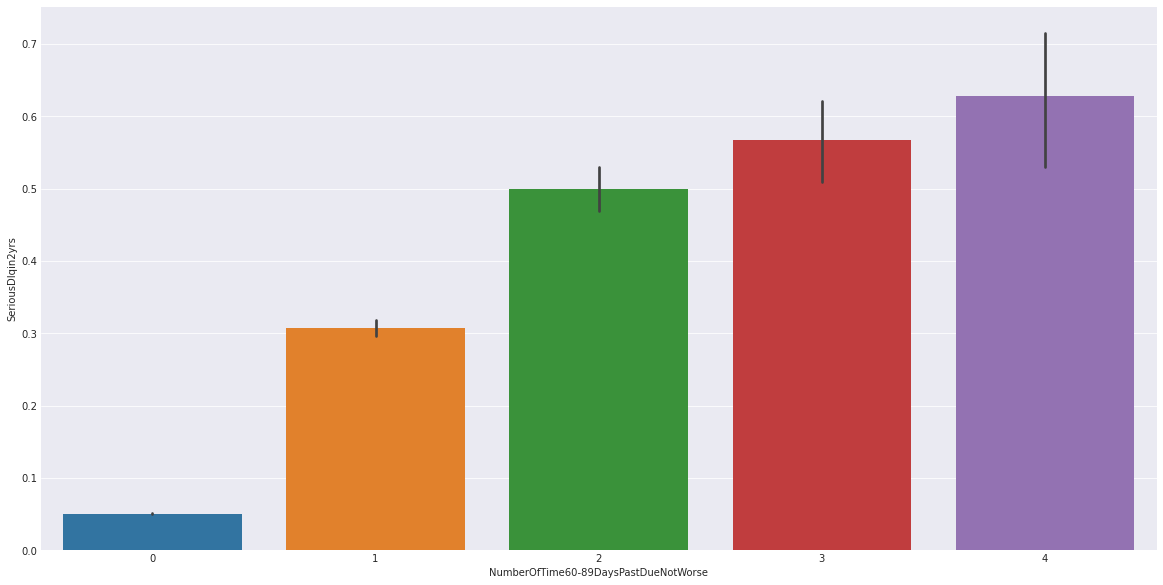

In [28]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="NumberOfTime60-89DaysPastDueNotWorse", y="SeriousDlqin2yrs")

---

In [30]:
df.DebtRatio.value_counts()

0.00       7634
0.01       4041
0.23       2099
0.25       2092
0.26       2069
           ... 
72.50         1
7302.00       1
7224.00       1
6981.00       1
4945.00       1
Name: DebtRatio, Length: 6763, dtype: int64

In [15]:
df.DebtRatio = df.DebtRatio.round(decimals = 2)

In [16]:
df = df.loc[df['DebtRatio'] != 0]
#df = df.loc[df['DebtRatio'] < 7]

<AxesSubplot:xlabel='DebtRatio', ylabel='SeriousDlqin2yrs'>

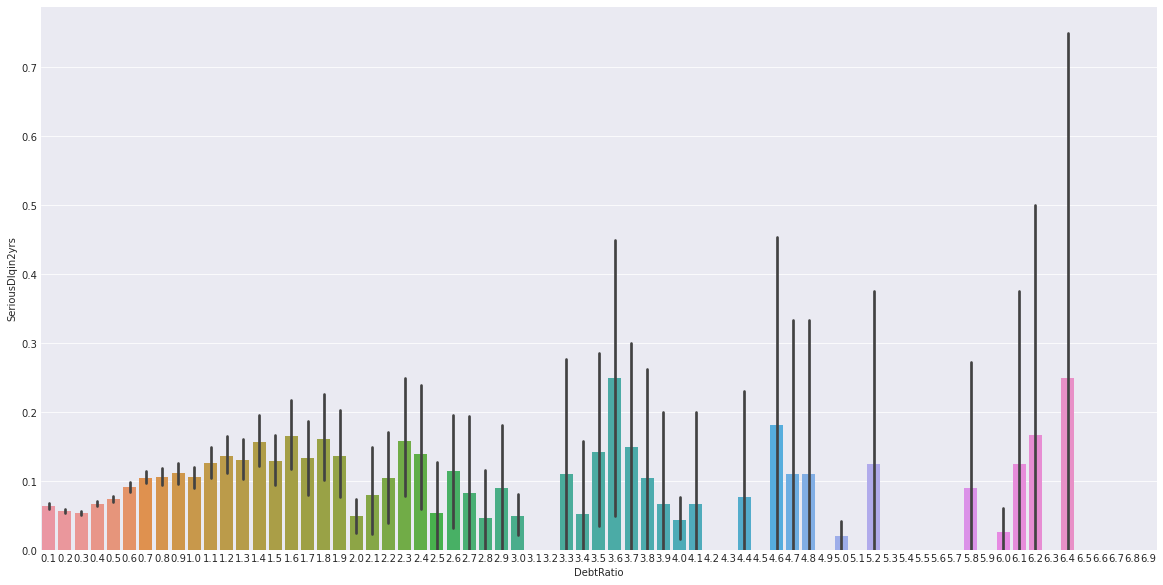

In [32]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="DebtRatio", y="SeriousDlqin2yrs")

---

In [33]:
df.MonthlyIncome.value_counts()

5000.0      40805
4000.0      15763
6000.0      12458
3000.0      12048
2000.0      10070
            ...  
111000.0        1
262000.0        1
131000.0        1
128000.0        1
107000.0        1
Name: MonthlyIncome, Length: 128, dtype: int64

In [17]:
df.MonthlyIncome = df.MonthlyIncome.round(decimals = -3)

In [159]:
#df = df.loc[df['MonthlyIncome'] < 36000]

<AxesSubplot:xlabel='MonthlyIncome', ylabel='SeriousDlqin2yrs'>

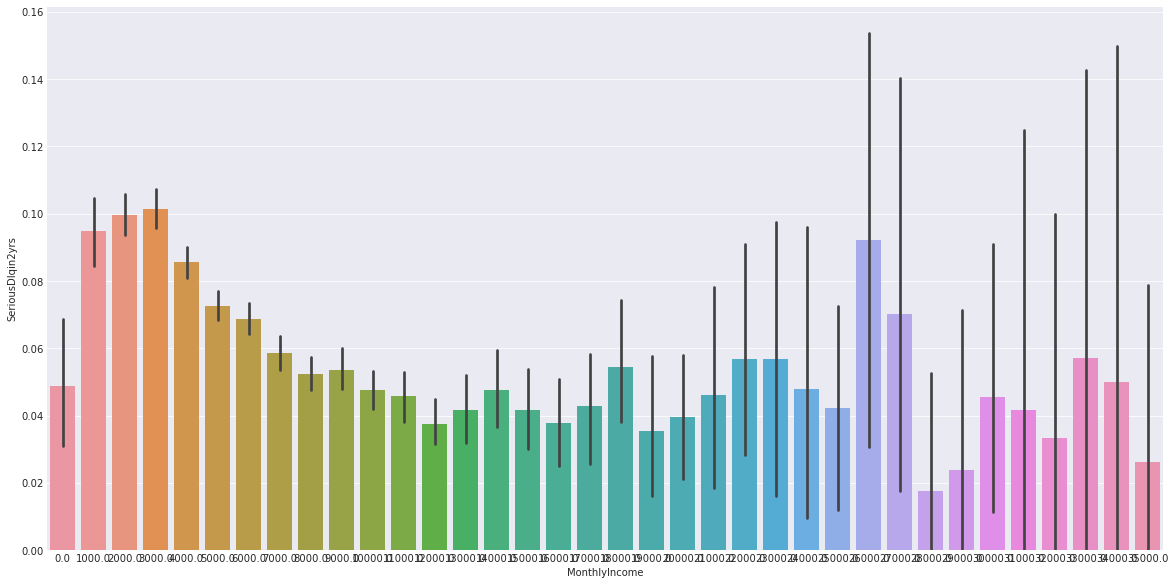

In [36]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="MonthlyIncome", y="SeriousDlqin2yrs")

---

In [169]:
df.RevolvingUtilizationOfUnsecuredLines.value_counts()

0.0        42509
0.1        25878
0.2        13239
1.0        13003
0.3         9684
           ...  
5451.0         1
1851.0         1
959.0          1
1171.0         1
20514.0        1
Name: RevolvingUtilizationOfUnsecuredLines, Length: 288, dtype: int64

In [18]:
df.RevolvingUtilizationOfUnsecuredLines = df.RevolvingUtilizationOfUnsecuredLines.round(decimals = 1)

In [161]:
#df = df.loc[df['RevolvingUtilizationOfUnsecuredLines'] < 6]

<AxesSubplot:xlabel='RevolvingUtilizationOfUnsecuredLines', ylabel='SeriousDlqin2yrs'>

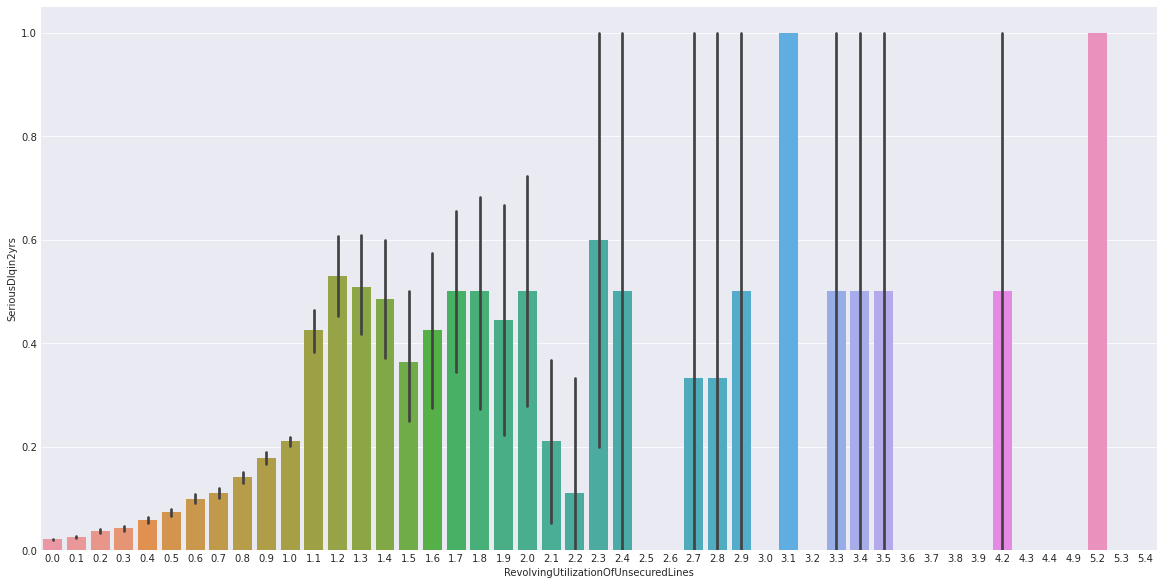

In [40]:
plt.figure(figsize=(20,10))
sns.barplot(data = df, x="RevolvingUtilizationOfUnsecuredLines", y="SeriousDlqin2yrs")

---

Используя  seaborn.pairplot (sns) визуализируйте данные

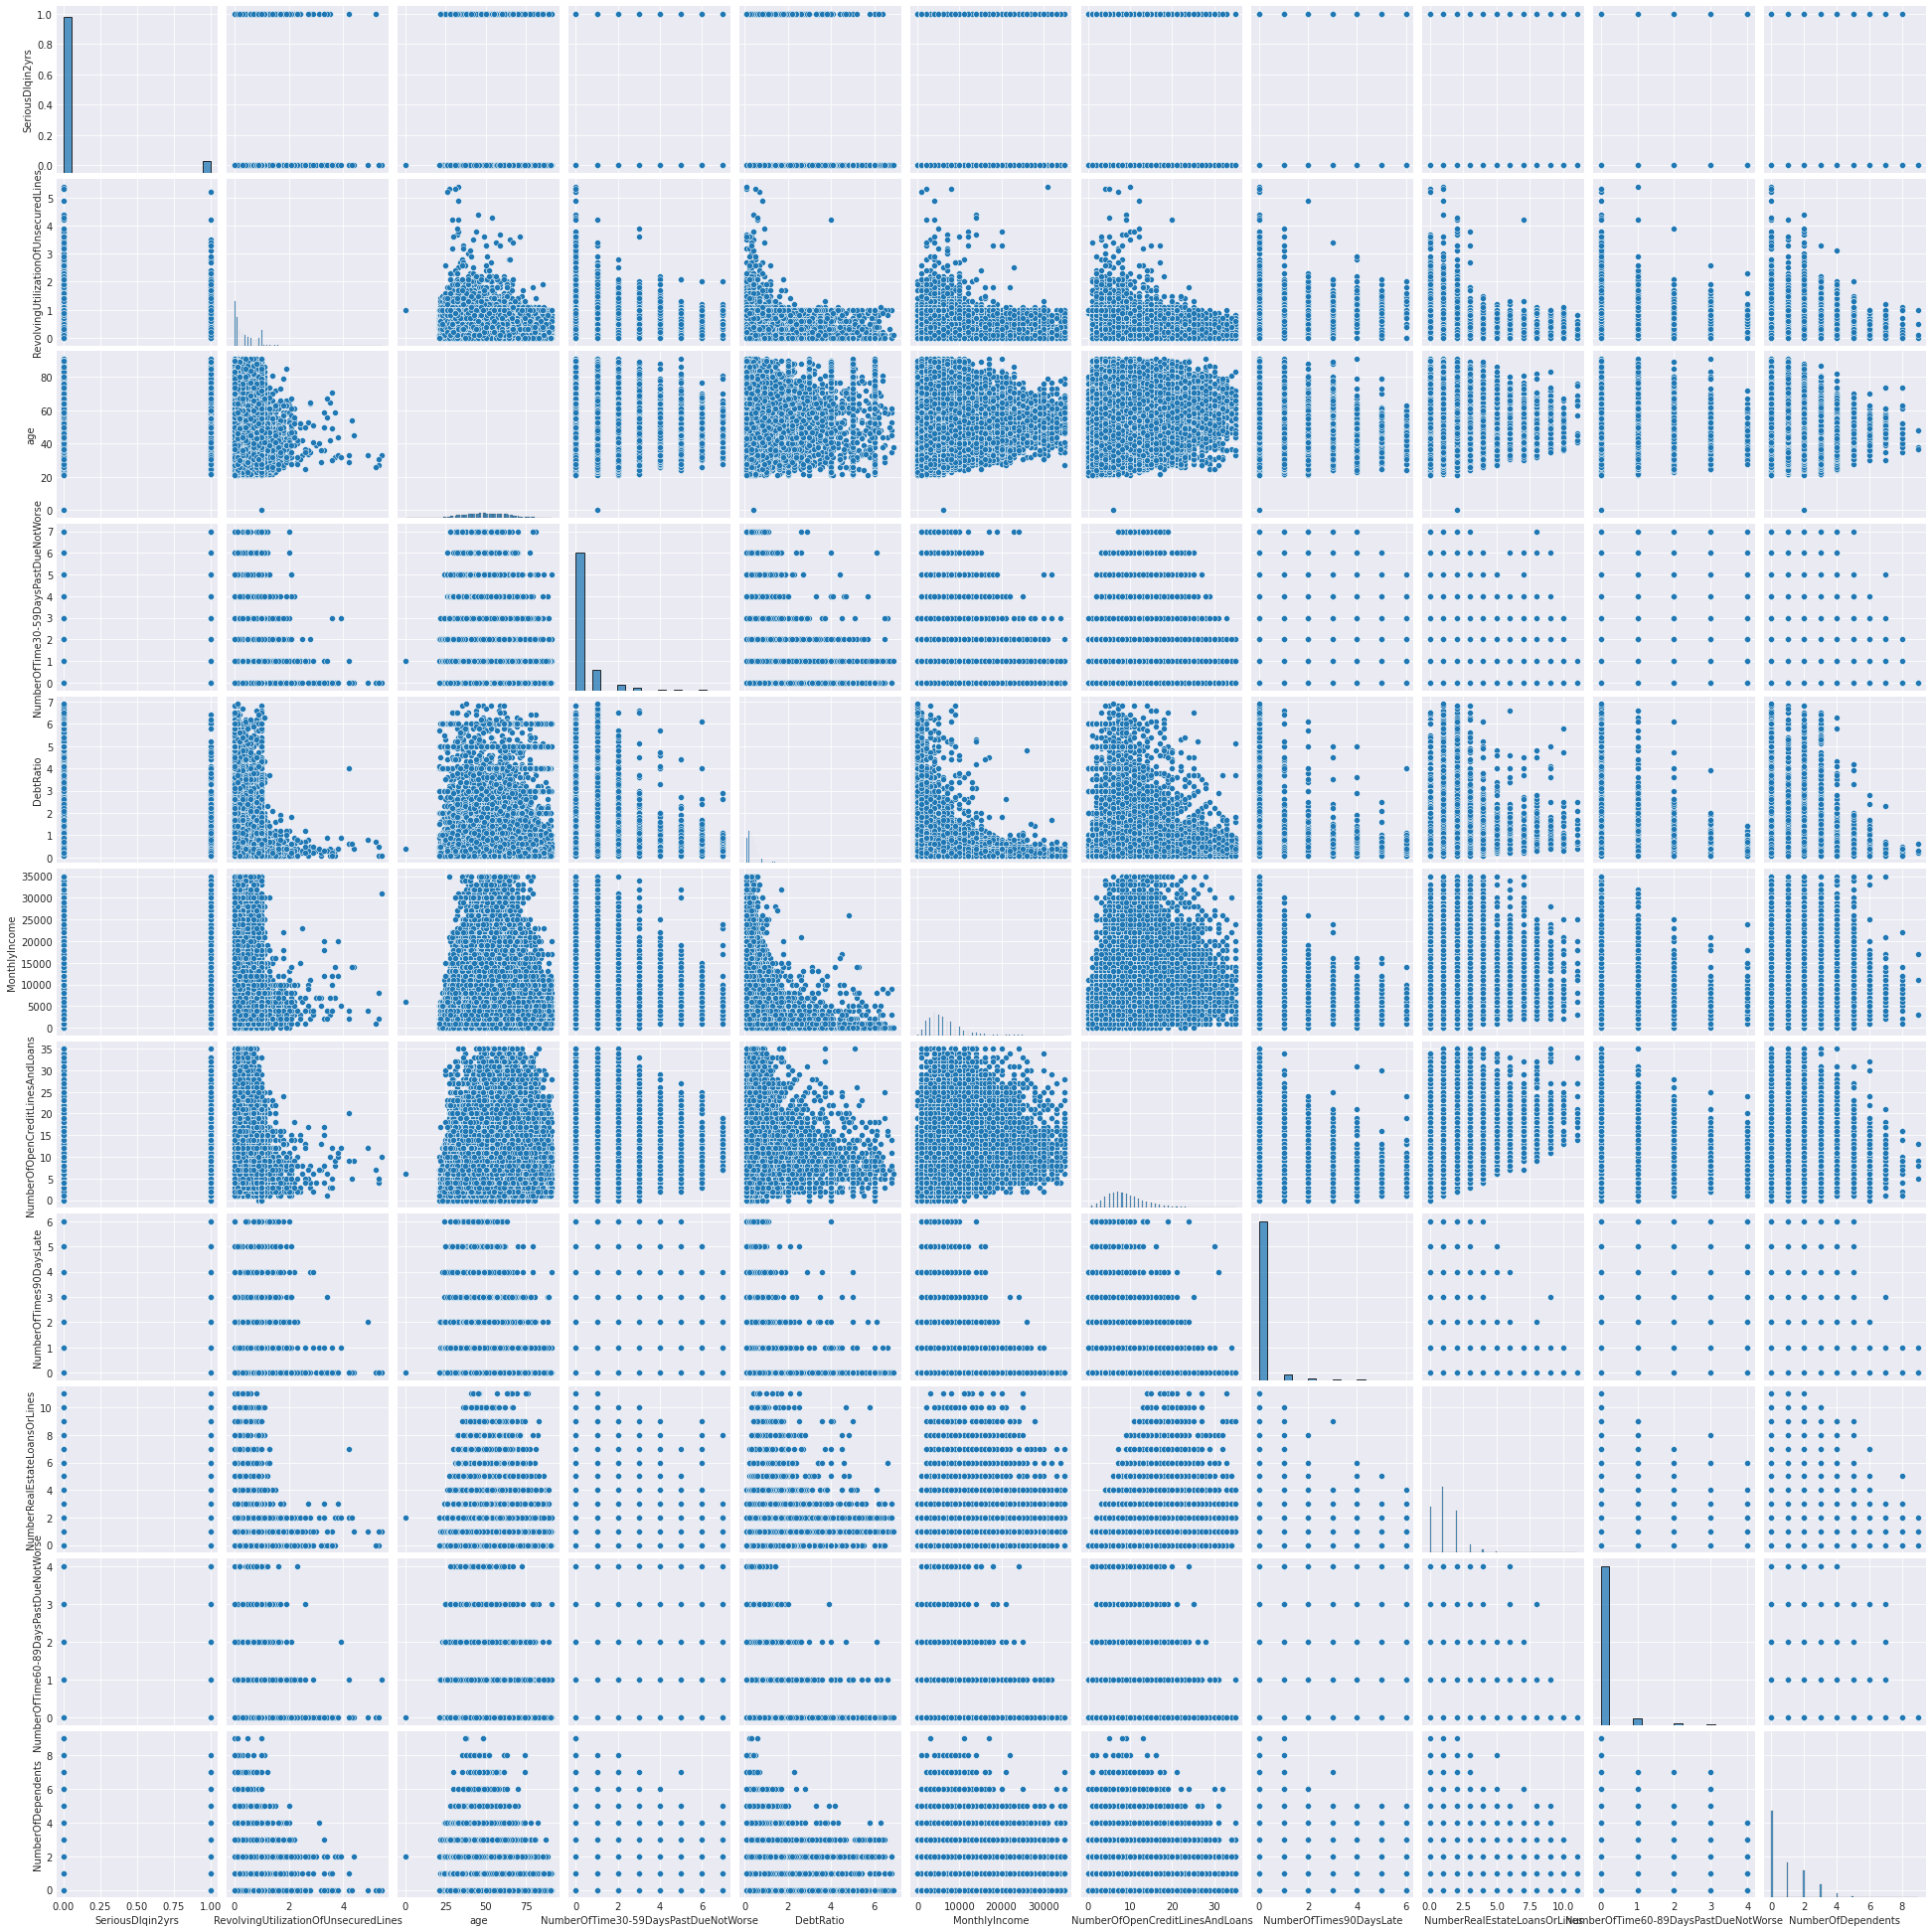

In [41]:
sns.pairplot(df)

Используя sns.heatmap постройте корреляционную матрицу

<AxesSubplot:>

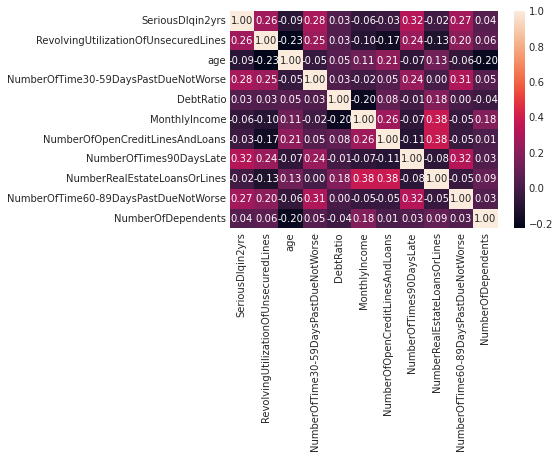

In [42]:
df_corr = df.corr()
sns.heatmap(df_corr, annot=True, fmt=".2f")

In [19]:
#результат чистки
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141371 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      141371 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  141371 non-null  float64
 2   age                                   141371 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  141371 non-null  int64  
 4   DebtRatio                             141371 non-null  float64
 5   MonthlyIncome                         141371 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       141371 non-null  int64  
 7   NumberOfTimes90DaysLate               141371 non-null  int64  
 8   NumberRealEstateLoansOrLines          141371 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  141371 non-null  int64  
 10  NumberOfDependents                    141371 non-null  float64
dtype

__Создание новых признаков__

1. Выберите признаки подлежащие бинаризации.
2. Осуществите бинаризацию.
3. Как влияет количество интервалов бинаризации на качество модели? 

Для создания новых признаков рекомендую ответить на следующие вопросы:
Как влияют количество иждевенцев у заемщика на просрочку выплат?
Какой тип кредитов чаще всего берет заемщик?

#### Без создания новых признаков roc_auc выше

In [133]:
#df.insert(1,'AgeCategory', 'null')
#df.loc[(df.age<=31), 'AgeCategory'] = 'youth' 
#df.loc[(df.age>31) & (df.age<=55), 'AgeCategory'] = 'mid-aged' 
#df.loc[(df.age>55) & (df.age<=70), 'AgeCategory'] = 'senior' 
#df.loc[(df.age>70), 'AgeCategory'] = 'old' 

#df['AgeCategory'].value_counts()

mid-aged    72751
senior      42340
old         14938
youth       11342
Name: AgeCategory, dtype: int64

In [134]:
#df.insert(2, 'DependentsCategory', 'null')
#df.loc[(df.NumberOfDependents==0), 'DependentsCategory'] = 'single' 
#df.loc[(df.NumberOfDependents==1), 'DependentsCategory'] = 'one_dep' 
#df.loc[(df.NumberOfDependents==2), 'DependentsCategory'] = 'two_dep' 
#df.loc[(df.NumberOfDependents>=3), 'DependentsCategory'] = 'three_plus_dep'  

#df['DependentsCategory'].value_counts()

single            83946
one_dep           25308
two_dep           19098
three_plus_dep    13019
Name: DependentsCategory, dtype: int64

In [135]:
#df = pd.concat([df, 
#                      pd.get_dummies(df['DependentsCategory'], prefix="DependentsCategory"),
#                      pd.get_dummies(df['AgeCategory'], prefix="AgeCategory")],
#                     axis=1)

#df.drop(['DependentsCategory', 'AgeCategory'], axis=1, inplace=True)

In [29]:
#scaler = StandardScaler()

In [30]:
#df[['age']] = scaler.fit_transform(df[['age']])
#df[['DebtRatio']] = scaler.fit_transform(df[['DebtRatio']])
#df[['MonthlyIncome']] = scaler.fit_transform(df[['MonthlyIncome']])
#df[['NumberOfOpenCreditLinesAndLoans']] = scaler.fit_transform(df[['NumberOfOpenCreditLinesAndLoans']])
#df[['NumberRealEstateLoansOrLines']] = scaler.fit_transform(df[['NumberRealEstateLoansOrLines']])
#df[['NumberOfTime60-89DaysPastDueNotWorse']] = scaler.fit_transform(df[['NumberOfTime60-89DaysPastDueNotWorse']])
#df[['NumberOfTime30-59DaysPastDueNotWorse']] = scaler.fit_transform(df[['NumberOfTime30-59DaysPastDueNotWorse']])
#df[['NumberOfTimes90DaysLate']] = scaler.fit_transform(df[['NumberOfTimes90DaysLate']])

__Выбор метрики__

В качестве метрики используется ROC-AUC score, согласно соренованию. Данная метрика подходит для данной задачи, так как мы хотим определять тех заемщиков, которые сильно задержат выплату кредита, но при этом выдавать кредиты хорошим клиентам. Также эта метрика хорошо работает со случаем несбалансированных классов (как в нашем случае).
Выберите способ перекрестной проверки! Какой из них подходит наилучшим образом...

Обучите 2 классификатора логистическую регрессию и случайный лес.
Для визуализации процесса обучения используйте прогрессбар tqdm

In [20]:
X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
rfc = RandomForestClassifier()
rfc_params = [
     {'max_depth': range(2, 22, 3),
      'max_features': ['log2', 'sqrt'],
      'min_samples_leaf': [1, 2, 4],
      'min_samples_split': [2, 5, 10],
      'n_estimators': [10, 100, 1000, 2000]}
]

lr = LogisticRegression()
lr_params = [
     { 'penalty' : ['l1','l2'], 
       'C'       : [0.001, 0.01, 0.05, 0.1, 1.0, 5, 10.0],
       'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}
]

In [ ]:
rfc_gridsearch = GridSearchCV(rfc, param_grid=rfc_params, n_jobs=-1, cv=5, verbose=10)
rfc_gridsearch.fit(X_train,y_train)
rfc_gridsearch.best_params_

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


In [23]:
lr_gridsearch = GridSearchCV(lr, param_grid=lr_params, n_jobs=-1, cv=5, verbose=10)
lr_gridsearch.fit(X_train,y_train)
lr_gridsearch.best_params_

Fitting 5 folds for each of 42 candidates, totalling 210 fits


{'C': 5, 'penalty': 'l2', 'solver': 'liblinear'}

In [46]:
pipe = make_pipeline(StandardScaler(),
                     RandomForestClassifier(n_estimators = 1000, max_depth = 20, max_features = 'sqrt'))

pipe.fit(X_train, y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)
print('roc_auc_score_train: {:.3f}'.format(metrics.roc_auc_score(y_train, y_pred_train)))
print('roc_auc_score_test:  {:.3f}'.format(metrics.roc_auc_score(y_test, y_pred_test)))

roc_auc_score_train: 0.848
roc_auc_score_test:  0.580


In [24]:
pipe = make_pipeline(StandardScaler(),
                     LogisticRegression(C = 5, penalty= 'l2', solver = 'liblinear'))

pipe.fit(X_train, y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print('roc_auc_score_train: {:.3f}'.format(metrics.roc_auc_score(y_train, y_pred_train)))
print('roc_auc_score_test:  {:.3f}'.format(metrics.roc_auc_score(y_test, y_pred_test)))

roc_auc_score_train: 0.575
roc_auc_score_test:  0.570


Оцените среднюю правильность выбранной модели

In [48]:
print(cross_val_score(rfc, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1))

[0.83057838 0.83312069 0.82970265 0.82838881 0.82863375]


In [49]:
print(cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1))

[0.78530006 0.76867838 0.776896   0.783532   0.76793989]


Данная модель дает результат 0.860890 на public leaderboard и 0.864706 на private.

__Общие выводы__

По результатам проведенного анализа, можно увидеть, что есть определенные зависимости и признаки просрочки кредита. 
Наблюдаются следующие закономерности:
   1. До 25 лет риск просрочки увеличивается, далее с возрастом снижается до 82 лет
   2. Наличие иждивенцов мало влияет на искомый параметр
   3. Риск просрочеи увеличивается, если у заемщика нет кредитов
   4. С увеличением количества числа кредитов на недвижимость риск просрочки увеличивается(максимум на 8 кредитах), после снижается.
   5. Чем больше у заемщика просрочек про предыдущим кредитам, тем выше вероятность невыплаты
   6. Нет четкой закономерности между коэффициентом задолженности и целевым признаком
   7. С ростом месячного дохода риск невыплаты снижается до дохода 16000, затем увеличивается
   8. Чем меньше отношение баланса к долгу, тем выше вероятность просрочки

Наибольшее влияние на целевой признак имеют наличие просрочек и отношение баланса к долгу.

Добавление новых признаков в моем случае снижало оценку ROC_AUC.